# Flow accumulation of the surface water flow
Flow accumulation is a critical step in hydrological modeling and analysis. It indicates how water flows across the terrain, accumulating from higher elevations down to lower elevations. Low flow accumulation values usually correspond to high catchment areas and high flow accumulation values to stream channels, rivers and areas with high erosion rates, such as gullies.

In this step it is important to use a DEM which has gone through the fill sink process. In this way we ensure a continuous representation of surface water flow.

As we will see in the Notebook "Catchment delineation" by determining where the water accumulates, flow accumulation helps define catchment or watershed boundaries. 

Here is how flow accumulation is calculated:

<left><img src="images/neighbour_cells.png" style="width: 300px; float:right"><h>
- **Determination of slope gradients and flow directions**: For each cell in the DEM, the downward gradient is determined by comparing the elevation of the cell with the elevations of its eight neighboring cells. The neighborings cells with the lowest elevations are considered the downstream cells, and flow is directed towards them.

- **Flow Accumulation**: Flow accumulation is calculated by distributing flow from each cell to its neighboring cells based on the relative slopes. Cells with steeper slopes in a particular direction receive more flow from the upstream cell in that direction. Flow accumulation is calculated by summing up the flow coming from all upstream cells.

- **Flow Routing**: Once the flow direction and accumulation are determined, it is possible to model the flow path of water across the entire DEM. This information is valuable for various hydrological analyses, such as predicting runoff patterns, identifying drainage networks, and evaluate how well connected are different areas of the catchment.

## Import (or load) the necessary libraries and iMPACT-tools
These tools will let us load and visulaize the DEM, compute the flow direction and flow accumulation and visualize and save the results.
##### Step 1: `Import tools`

In [1]:
import numpy as np  # for numerical operations and array handling
from numba import njit  # for just-in-time (JIT) compilation to speed up computations
# Import the necessary iMPACT-tools
from tools.plot_dem import plot3d_dem
from tools.flow_accumulation import nanargmax, direction_lowest_neighbour, flow_accumulation_Dinf
from tools.file_IO import open_raster, save_as_raster

You can also find these tools in the Python files stored in the */tools* folder
## Load the filled DEM of the area of study

<left><img src="images/open_raster.png" width="200px">

##### Step 2: `Open the file and plot the filled DEM`

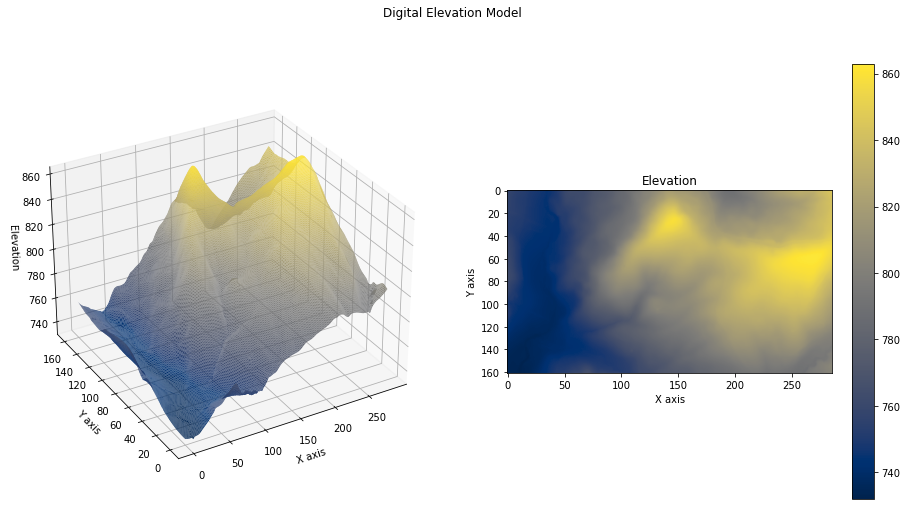

In [2]:
path = 'inputs/dem/'
file = 'filled_dem.tif'
dem, dem_metadata = open_raster(path,file)
dem_resol= dem_metadata['transform'][0]
plot3d_dem(dem)

## Run the function to compute the slope gradient

In [3]:
def slope_gradient(dem, dem_resol=5):
    """Calculate the slope gradient using the elevation data."""
    # Use numpy's gradient function to compute the slope in x and y directions
    dx, dy = np.gradient(dem, dem_resol)
    # Calculate the magnitude of the gradient
    slope = np.sqrt(dx**2 + dy**2)
    return slope

##### Step 3: `Calculate the slope gradient of the DEM`

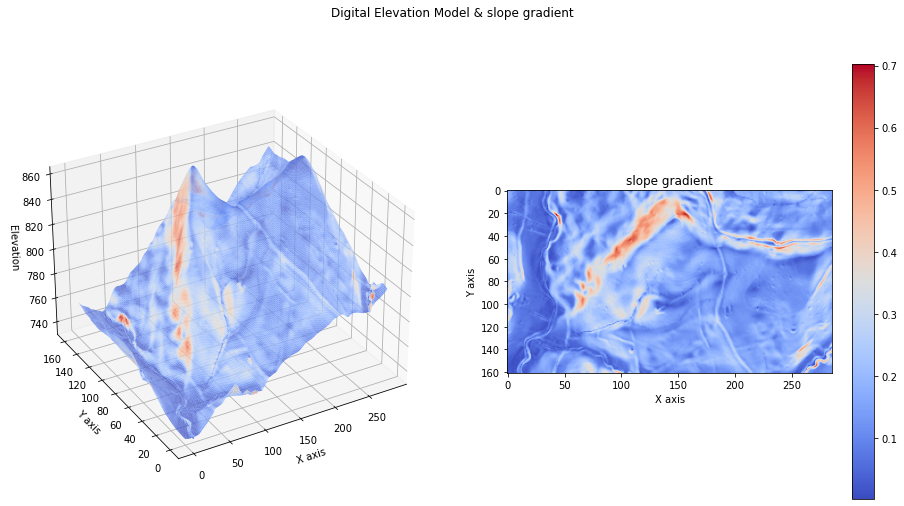

In [4]:
slope = slope_gradient(dem, dem_resol)
plot3d_dem(dem,slope,'slope gradient')

## Run the function to compute the flow accumulation
There are several methods available to calculate flow accumulation, but here we will see the two most popular ones, D8 and Dinf. The difference between these methods is mainly in how surface water flow is distributed to the neighbouring cells.

### D8 Method 
Also known as the "steepest descent" method, is a common approach used in hydrology

<left><img src="images/fa_D8.png" width="300px">

- Simpler and computationally less expensive: each cell contributes flow to only one downslope neighbor, typically based on steepest descent or slope.
- May oversimplify flow patterns, especially in areas with complex topography, leading to less accurate results.

In [5]:
@njit
def flow_accumulation_D8(dem, slope, dem_resol=5, num_iterations=None):
    """
    Calculate the flow accumulation using the D8 method for a digital elevation model (DEM).

    Args:
        dem (numpy.ndarray): A 2D array representing the elevation data.
        dem_resol (float, optional): The resolution of the DEM grid, representing the physical distance between adjacent cells. Default is 5.
        num_iterations (int, optional): Maximum number of iterations to perform. If None, process all non-NaN cells.

    Returns:
        slope (numpy.ndarray): The slope gradient for each cell.
        flow_dir (numpy.ndarray): Flow direction values for each cell, encoded as angles or direction indices.
        flow_acc (numpy.ndarray): Flow accumulation values for each cell, representing the number of upstream cells contributing to the flow.
        flow_rout_up_row (numpy.ndarray): Row indices of upstream cells for each processed cell.
        flow_rout_up_col (numpy.ndarray): Column indices of upstream cells for each processed cell.
        flow_rout_down_row (numpy.ndarray): Row indices of downstream cells for each processed cell.
        flow_rout_down_col (numpy.ndarray): Column indices of downstream cells for each processed cell.
        flow_rout_contrib (numpy.ndarray): Contribution count from each cell to its downstream neighbour (initially set to 1 for each cell).
        flow_rout_slope (list): Slope gradients for each flow-routing path between upstream and downstream cells.
    """
    # Create a temporary copy of the DEM to work with
    dem_temp = dem.copy()
    
    # Initialize the flow accumulation array; start with a value of 1 for each cell
    flow_acc = dem.copy() / dem.copy()
    
    # Initialize the flow direction array; initially all zeros
    flow_dir = np.zeros_like(dem, dtype=np.float64)

    # Calculate the total number of non-NaN cells in the DEM
    num_nonan = np.sum(~np.isnan(dem))

    # If a specific number of iterations is set, limit the number of cells to process
    if num_iterations is not None:
        num_nonan = min(num_iterations, np.sum(~np.isnan(dem)))
        
    # Initialize arrays to store upstream and downstream cell indices for each processed cell
    flow_rout_up_row = np.zeros(num_nonan, dtype=np.int64)
    flow_rout_up_col = np.zeros(num_nonan, dtype=np.int64)
    flow_rout_down_row = np.zeros(num_nonan, dtype=np.int64)
    flow_rout_down_col = np.zeros(num_nonan, dtype=np.int64)
    
    # Initialize an array to track the contribution count from each cell to its downstream neighbour
    flow_rout_contrib = np.zeros(num_nonan, dtype=np.int64)
    
    # Initialize a list to store the slope gradients for each flow-routing path
    flow_rout_slope = []

    for i in range(num_nonan - 1):
        # Find the index of the highest remaining cell in the temporary DEM
        high_cell_index = nanargmax(dem_temp)
        
        # Convert the linear index to a row, column pair
        high_cell = high_cell_index // dem_temp.shape[1], high_cell_index % dem_temp.shape[1]
        
        # Calculate the direction to the lowest neighbouring cell using the D8 method
        dx, dy, flow_dir[high_cell] = direction_lowest_neighbour(high_cell[0], high_cell[1], dem)

        # Add the flow accumulation of the current cell to its lowest neighbouring cell
        flow_acc[high_cell[0] + dx, high_cell[1] + dy] += flow_acc[high_cell]

        # Store the row and column indices of the current (upstream) cell
        flow_rout_up_row[i] = high_cell[0]
        flow_rout_up_col[i] = high_cell[1]
        
        # Store the row and column indices of the lowest (downstream) neighbouring cell
        flow_rout_down_row[i] = high_cell[0] + dx
        flow_rout_down_col[i] = high_cell[1] + dy
        
        # Set the contribution count to 1 (indicating one cell contributing to downstream flow)
        flow_rout_contrib[i] = 1
        
        # Append the calculated slope gradient for this flow path
        flow_rout_slope.append(slope[high_cell])

        # Mark the processed cell as inactive by setting it to NaN in the temporary DEM
        dem_temp[high_cell[0], high_cell[1]] = np.nan

    return flow_dir, flow_acc, flow_rout_up_row, flow_rout_up_col, flow_rout_down_row, flow_rout_down_col, flow_rout_contrib, flow_rout_slope


##### Step 4a: `Run the D8 function to calculate:
- DEM slope gradient
- flow accumulation
- flow direction
- flow routing

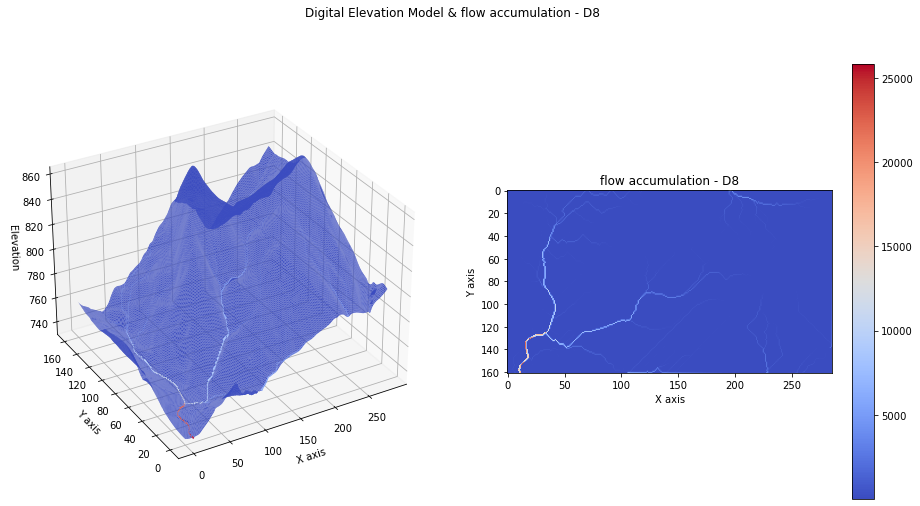

In [6]:
flow_dir_D8,flow_acc_D8,flow_rout_up_row_D8, flow_rout_up_col_D8, flow_rout_down_row_D8, flow_rout_down_col_D8, flow_rout_contrib_D8, flow_rout_slope_D8 = flow_accumulation_D8(dem,slope,dem_resol)
plot3d_dem(dem,flow_acc_D8,'flow accumulation - D8')

### An alternative: D-infinity (Dinf) method
Flow is distributed from each cell to all its neighboring cells based on the relative slope values in each direction. For upslope neighbouring cells, no flow is assigned.
    
<left><img src="images/fa_Dinf.png" width="300px">

- More complex and computationally intensive: allows each cell to contribute flow to multiple downslope neighbors, based on the relative slope values in each direction.
- It captures more complex flow patterns and can handle flow routing across ridges and divides more effectively.
##### Step 4b: `Run the Dinf function`

C:\Users\Usuario\OneDrive - Universidad de Córdoba\Projects\iMPACT\iMPACT-erosion\iMPACT-Start\tools\flow_accumulation.py:192: RuntimeWarning: invalid value encountered in true_divide
  flow_contributions = slopes / np.nansum(slopes)  # Normalize slopes to get flow contributions


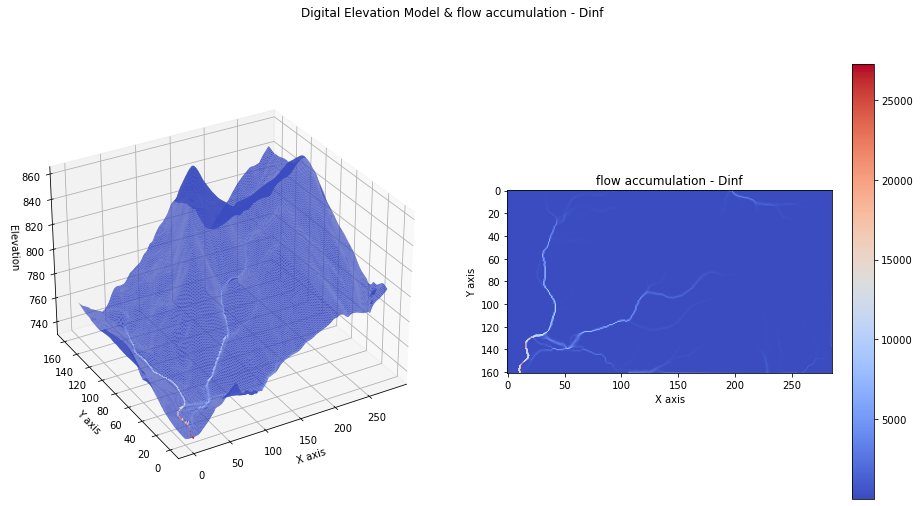

In [7]:
flow_acc_Dinf,flow_rout_up_row_Dinf,flow_rout_up_col_Dinf,flow_rout_down_row_Dinf, flow_rout_down_col_Dinf, flow_rout_contrib_Dinf, flow_rout_slope_Dinf = flow_accumulation_Dinf(dem,dem_resol)
plot3d_dem(dem,flow_acc_Dinf,'flow accumulation - Dinf')

In general, if computational efficiency is a priority and the terrain is relatively simple, the D8 method may suffice. However, for more accurate results in areas with complex terrain, the D-infinity method (Dinf) is often preferred despite its higher computational cost.

## Save the slope, flow direction and accumulation maps as raster files 
<left><img src="images/save_raster.png" width="200px">
##### Step 4: `Save the results`

In [8]:
# Save the slope, flow direction, and flow accumulation maps as raster (TIFF) files
save_as_raster('inputs/slope/','slope_' + file, slope, dem_metadata)
save_as_raster('inputs/flow_dir/','flow_dir_D8_' + file, flow_dir_D8, dem_metadata)
save_as_raster('inputs/flow_acc/','flow_acc_D8_' + file, flow_acc_D8, dem_metadata)
save_as_raster('inputs/flow_acc/','flow_acc_Dinf_' + file, flow_acc_Dinf, dem_metadata)